You may need to install some packages

VIA PIP

pip install networkx[default]

pip install netgraph

VIA CONDA

conda install anaconda::networkx

conda install -c conda-forge netgraph

In [1]:
from time import time

import scipy.sparse as sp
import scipy.sparse.linalg as spl
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from netgraph import ArcDiagram

For more information about sparse matrices, look at "https://docs.scipy.org/doc/scipy/reference/sparse.html"

In [3]:
# function that allocates only a fraction of non zero entries; the others are completely negligible. I can also switch to sparse matrices and 
# viceversa. 
# To store I have different methods, but basically i call the type of the matrix (csc_matrix), then the non zero values in rows and columns and
# then the shape. NB: you can get the sparse matrix from the dense one: using matrix = sp.csc_matrix(matrix).
# get_sparsity get the percentage of the sparsity of my matrix, and i can see the advantage.

def generate_symmetric_sparse_matrix(size, density, sparse=True):
    """
    Generate a random uniform symmetric sparse matrix of shape (size, size).

    Parameters
    ----------
    size : int
        Size of the matrix
    density : float
        ratio of non-zero values in your matrix
    sparse : bool, optional
        If True, give as output a sparse matrix. If False, a numpy array, by default True
    """

    # total entries of the matrix
    num_elems = size**2
    # fix an amount of nonzero entries based on density parameter
    num_nonzeo_elems = int(np.ceil(num_elems*density/2))
    # Random choose the rows and cols indices for storing non zero elements
    elem_idxs = np.random.randint(0, size, size=(num_nonzeo_elems, 2))
    # Random create nonzero elements
    elems = np.random.rand(num_nonzeo_elems)

    # Save the matrix information (values, (row_list, col_list), shape) as a sparse one
    matrix = sp.csc_matrix((elems, (elem_idxs[:, 0], elem_idxs[:, 1])), shape=(size, size))
    matrix += matrix.transpose()
    if not sparse:
        # convert to normal dense matrix
        matrix = matrix.todense()


    # NOTE: you can get the sparse matrix from the dense one:
    # matrix = sp.csc_matrix(matrix)
    return matrix


def get_sparsity(matrix):
    # MEASURE SPARSITY of a certain matrix
    num_nonzero = matrix.nnz
    # Total number of elements
    total_elements = matrix.shape[0] * matrix.shape[1]
    # Calculate sparsity
    sparsity = 1 - (num_nonzero / total_elements)
    print(f"SPARSITY: {round(sparsity*100,3)}%")

In [4]:
# here i test it, with different values of the density. and i compare 2 methods: the first k = how many eig I want, since with sparse matrix
# i cannot get the entire spectrum. Also, i can see that trying with different k performance will change.
# the second diagonalization is fully diagonalization of the matrix.
# if i want to get k=10 eigs the sparse matrix method becomes to be less efficient. i can play with different size.



# Try to change k, the number of eigenvalues you search for
size = 1000
num_densities = 20

# Generate different values of the density
densities = np.logspace(-4, 0, num_densities)
timings = np.zeros((num_densities, 2))

for idx, sparsity in enumerate(densities):
    matrix = generate_symmetric_sparse_matrix(size, sparsity)

    tic = time()
    eigvl, eigvc = spl.eigsh(matrix, k=1, which="SA")
    timings[idx, 0] = time() - tic

    tic = time()
    eigvl, eigvc = np.linalg.eigh(matrix.todense())
    timings[idx, 1] = time() - tic

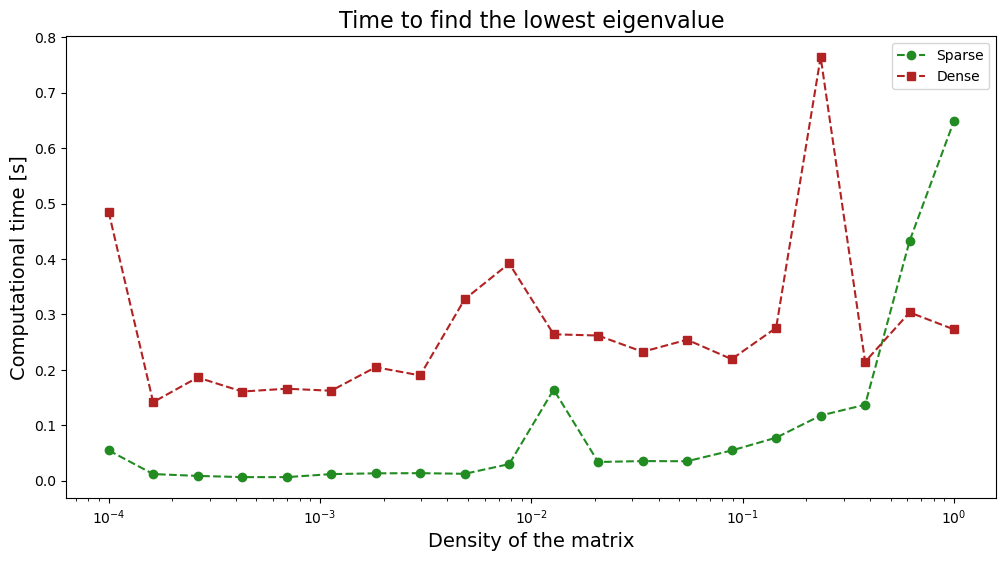

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(densities, timings[:, 0], "o--", label="Sparse", color="forestgreen")
ax.plot(densities, timings[:, 1], "s--", label="Dense", color="firebrick")
ax.legend()
ax.set_xscale("log")

ax.set_xlabel("Density of the matrix", fontsize=14)
ax.set_ylabel("Computational time [s]", fontsize=14)
ax.set_title("Time to find the lowest eigenvalue", fontsize=16)

plt.show()

## Nearest neighbors interactions

In [5]:
def generate_hamiltonian(adj_mat):
    """
    Starting from an adjecency matrix,
    build the quantum ising hamiltonian
    of the system. Notice that for an
    adjecency matrix (nxn) you obtain an
    hamiltonian (2^n, 2^n)

    Parameters
    ----------
    adj_mat : sp.csc_matrix
        Adjacency matrix codifying the interactions
        of your system

    Returns
    -------
    sp.csc_matrix
        Hamiltonian of the system
    """
    sz = np.array([[1, 0], [0, -1]])
    sx = np.array([[0, 1], [1, 0]])
    num_sites = adj_mat.shape[0]
    ham = sp.csc_matrix((2**num_sites, 2**num_sites))


    nz = adj_mat.nonzero()
    for ii, jj in zip(nz[0], nz[1]):
        # On-site terms
        if ii == jj:
            op = sp.identity(2**(ii))
            op = sp.kron(op, sz)
            op = sp.kron(op, sp.identity(2**(num_sites-ii-1)) )
        # Interaction term
        else:
            i1 = min(ii, jj)
            j1 = max(ii, jj)

            op = sp.identity(2**(i1))
            op = sp.kron(op, sx)
            op = sp.kron(op, sp.identity(2**(j1-i1-1)) )
            op = sp.kron(op, sx)
            op = sp.kron(op, sp.identity(2**(num_sites-j1-1 )) )
        ham += adj_mat[ii, jj]*op

    return ham

def plot_adj_matrix(adj_mat, fig=None, ax=None):
    """
    Plot an adjacency matrix using imshow and
    highlighting the diagonal

    Parameters
    ----------
    adj_mat :  sp.csc_matrix
        Adjacency matrix codifying the interactions
        of your system
    fig : matplotlib.Figure, optional
        figure if you want to plot on an already existing figure.
        If passed, you should pass also the ax, by default None
    ax : matplotlib.axes, optional
        ax if you want to plot on an already existing ax.
        If passed, you should pass also the figure, by default None

    Returns
    -------
    None
    """
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    num_sites = adj_mat.shape[0]
    im = ax.imshow(adj_mat.todense(), cmap="seismic")
    ax.set_title("Interaction matrix", fontsize=16)

    line = np.arange(0, num_sites+1) - 0.5
    ax.plot(line, line, "--", color="black")
    cbar = fig.colorbar(im, label="Interaction strength")

    ax.set_xticks(np.arange(0, num_sites, 8))
    ax.set_yticks(np.arange(0, num_sites, 8))

    plt.show()

def plot_chain_interactions(adj_mat):
    """
    Plot the interaction of an adjecency matrix as a
    graph on a chain

    Parameters
    ----------
    adj_mat :  sp.csc_matrix
        Adjacency matrix codifying the interactions
        of your system

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(12,6))
    graph = nx.from_scipy_sparse_array(adj_mat)

    ArcDiagram(graph, node_order=range(len(graph)), node_color="black", node_size=0.5, edge_width=0.5, ax=ax, edge_alpha=0.9)
    plt.show()

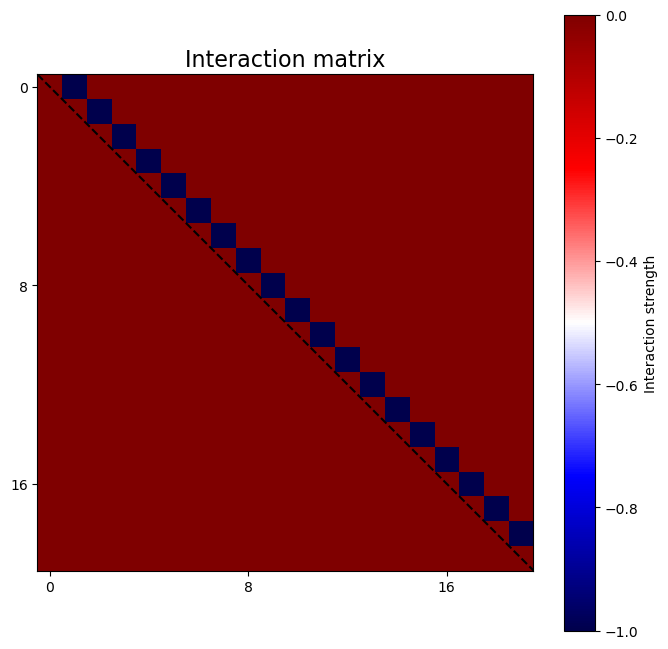

/home/sdruci/anaconda3/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


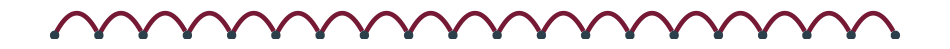

In [6]:
num_sites = 20

adj_mat = sp.csc_matrix(
    (
        -np.ones((num_sites-1)),
        ([ii for ii in range(0, num_sites-1)], [ii for ii in range(1, num_sites)])
    ),
    shape=(num_sites, num_sites)
)

plot_adj_matrix(adj_mat)
plot_chain_interactions(adj_mat)

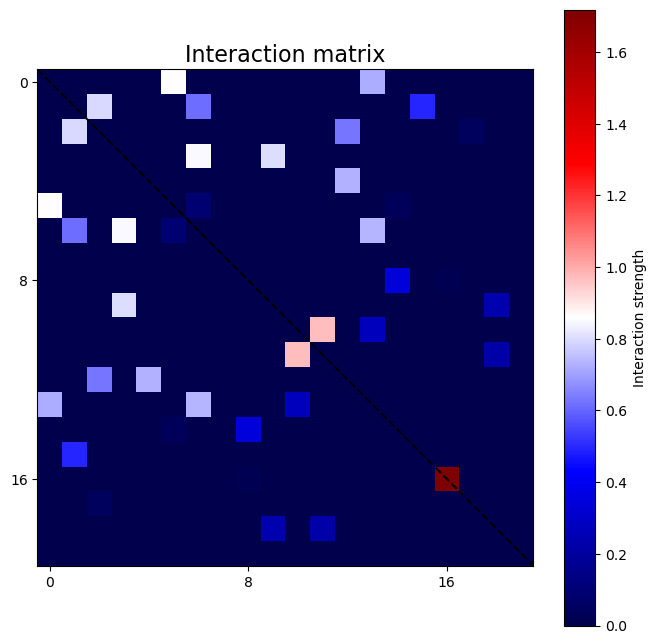

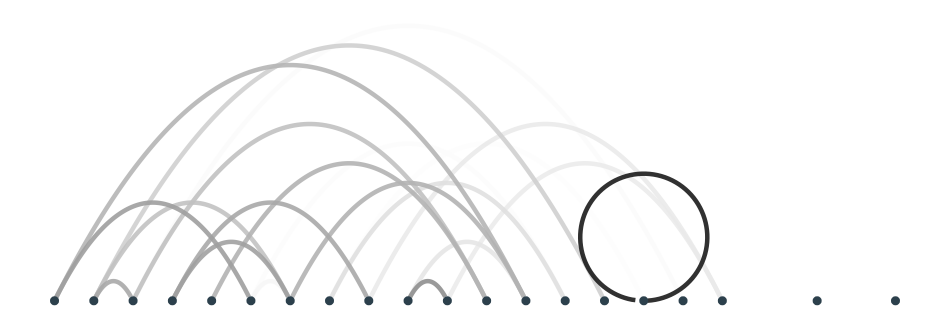

In [7]:
random_adj_mat = generate_symmetric_sparse_matrix(20, 0.1)
plot_adj_matrix(random_adj_mat)
plot_chain_interactions(random_adj_mat)